In [1]:
!pip install opencv-python
!pip install tensorflow

In [64]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import warnings
warnings.filterwarnings('ignore')

##### get all the train data from the train folder

In [4]:
base_path = os.getcwd() 
base_path

'D:\\Northeastern\\Fall2024\\DS5220\\Project'

In [54]:
train_data = []
train_folder = os.path.join(base_path, 'asl_alphabet_train')

for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    image_file = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) 
                 if os.path.isfile(os.path.join(label_folder, f))]
    train_data += image_file
    
train_df = pd.DataFrame(train_data)

In [55]:
train_df

,label,path
0,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
1,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
2,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
3,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
4,A,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
...,...,...
86995,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
86996,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
86997,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...
86998,Z,D:\Northeastern\Fall2024\DS5220\Project\asl_al...


In [56]:
train_df['path'][0]

'D:\\Northeastern\\Fall2024\\DS5220\\Project\\asl_alphabet_train\\A\\A1.jpg'

In [57]:
test_data = []
test_folder = os.path.join(base_path, 'asl_alphabet_test')

test_data = [
    {'label': file.split('_')[0], 'path': os.path.join(test_folder, file)}
    for file in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, file))
]
    
test_df = pd.DataFrame(test_data)

In [59]:
test_df['path'][0]

'D:\\Northeastern\\Fall2024\\DS5220\\Project\\asl_alphabet_test\\A_test.jpg'

# EDA

In [7]:
labels = train_df['label'].unique().tolist()
print(labels)

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87000 entries, 0 to 86999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   87000 non-null  object
 1   path    87000 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [9]:
 train_df.isnull().sum()

label    0
path     0
dtype: int64

In [10]:
image_shapes = []
for path in train_df['path']:
    img = cv2.imread(path)
    image_shapes.append(img.shape)
pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Channels']).describe()

,Height,Width,Channels
count,87000.0,87000.0,87000.0
mean,200.0,200.0,3.0
std,0.0,0.0,0.0
min,200.0,200.0,3.0
25%,200.0,200.0,3.0
50%,200.0,200.0,3.0
75%,200.0,200.0,3.0
max,200.0,200.0,3.0


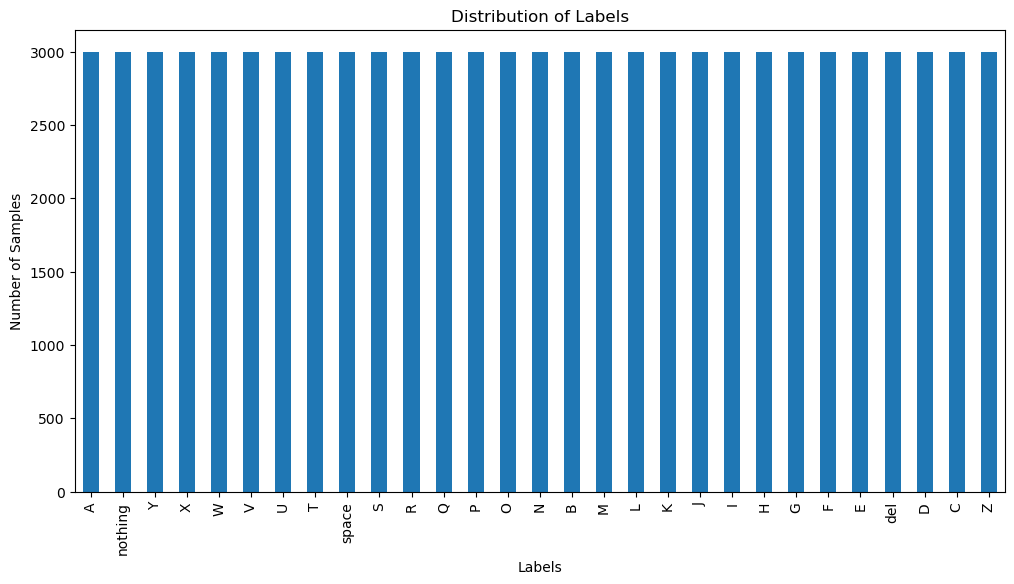

In [11]:
label_counts = train_df['label'].value_counts()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

In [12]:
def show_image(label, size):
    """
    Show the train image based on the input label and size  

    Args: 
        label: input label 
        size: image size

    Returns:
        None
    """
    rows = train_df[train_df['label']==label]['path']
    rand_img = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[rand_img]

    img = cv2.imread(path)
    img = cv2.resize(img, size)
    
    plt.figure()
    plt.imshow(img)

##### images with different size

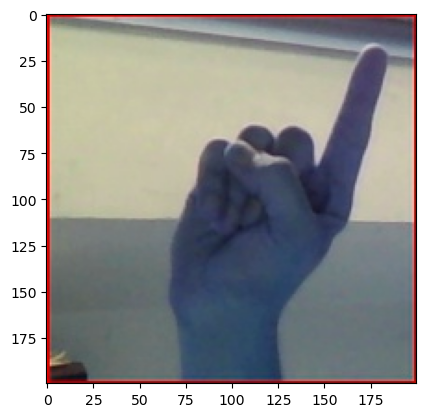

In [13]:
original_size = 200, 200
show_image('A', original_size)

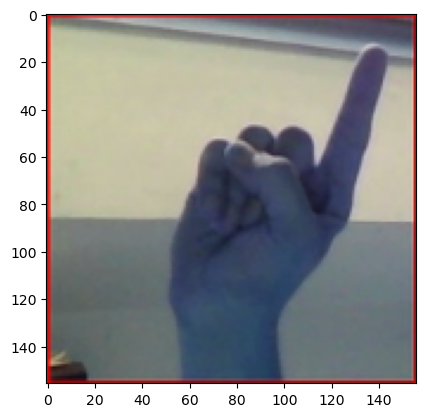

In [14]:
size = 156, 156
show_image('A', size)

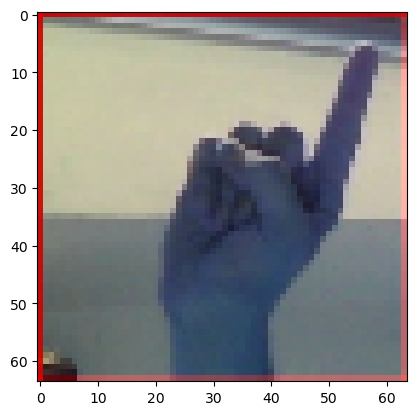

In [15]:
size = 64,64
show_image('A', size)

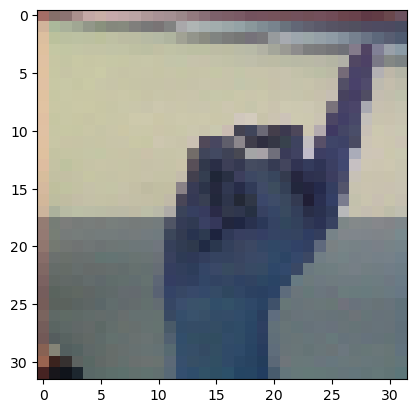

In [16]:
size = 32,32
show_image('A', size)

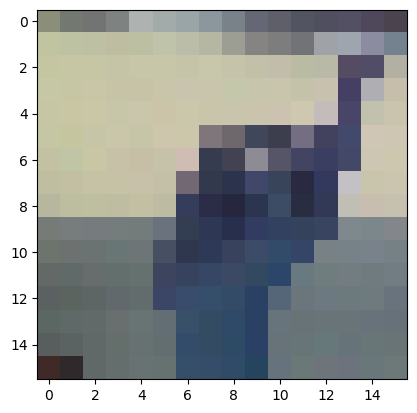

In [17]:
size = 16,16
show_image('A', size)

=> let's choose 32,32 size to train model and choose 16, 16 for reduced size to train CNN  models

In [18]:
target_size = 32,  32
reduced_size = 16, 16

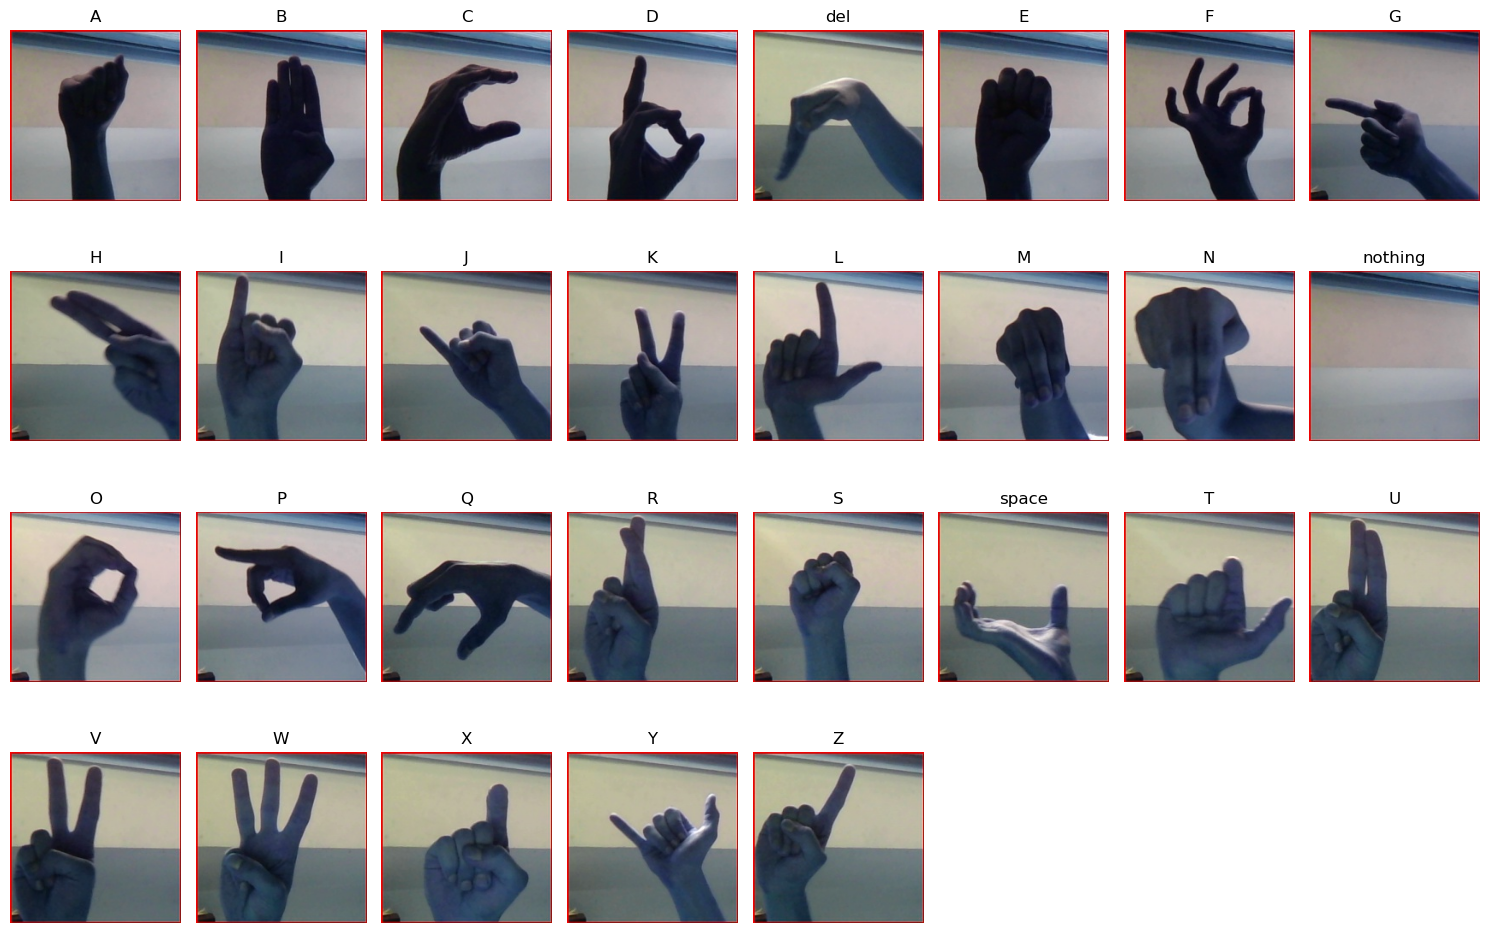

In [19]:
# Get all the labels
labels = train_df['label'].unique() 

# Plot the graph to show images of all the labels
plt.figure(figsize=(15, 10))
for i, label in enumerate(labels):
    label_row = train_df[train_df['label'] == label].iloc[0]
    image_path = label_row['path']

    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, original_size)

    plt.subplot(4, 8, i + 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

##### Some of the letters have  similar symbols:
-  A is similar to E
-  M and N are similar
-  V and K are similar
-  ...

=> Check models with 2 letters that have similar and different shapes to compare.

# Data Processing:

In [20]:
# X = []
# y = []

# for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
#     img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE) 
#     img_resized = cv2.resize(img, target_size)
#     img_flattened = img_resized.flatten()
    
#     X.append(img_flattened)
#     y.append(row['label'])

# X = np.array(X)
# y = np.array(y)

def preprocess_images(size):
    """
    Preprocess images to a specific size
    Normalize the resized images.

    Args: 
        size: input image size
    """
    X = []
    y = []

    for _, row in train_df.iterrows():
        img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, size)
        img_normalized = img_resized.astype('float32') / 255.0
        
        X.append(img_normalized)
        y.append(row['label'])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [21]:
X, y = preprocess_images(target_size)

In [22]:
X.shape

(87000, 32, 32)

In [23]:
y

array(['A', 'A', 'A', ..., 'Z', 'Z', 'Z'], dtype='<U7')

# Modelling:

#### 1. Logistic Regression:

##### Two letters:

In [24]:
def logistic_regression_binary(label_1, label_2, size, roc_label):
    """
    Train a logistic regression model using two specific labels.

    Args:
        label_1: the first label 
        label_2: the second label
        size: the input of the image size
        roc_label: the label title for ROC graph
    """
    X, y = preprocess_images(size)
    
    mask = (y == label_1) | (y == label_2)
    X = X[mask]
    y = y[mask]
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape the 3D to 2D
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print('Accuracy: ' + str(accuracy))
    print('Recall: ' + str(recall))
    print('Precision: ' + str(precision))
    print('F1_score: ' + str(f1))
    print('Classification Report: ')
    print(report)

    y_prob = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    print('AUC Score: ' + str(auc_score))

    print('Confusion Matrix: ')
    sns.heatmap(conf_matrix, annot=True)

    # plot AUC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.title(roc_label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

Accuracy: 0.8991666666666667
Recall: 0.8989928605373079
Precision: 0.8992491657397108
F1_score: 0.8990903537466877
Classification Report: 
              precision    recall  f1-score   support

           A       0.90      0.91      0.90       613
           E       0.90      0.89      0.90       587

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200

Confusion Matrix: 
AUC Score: 0.9694023027476787


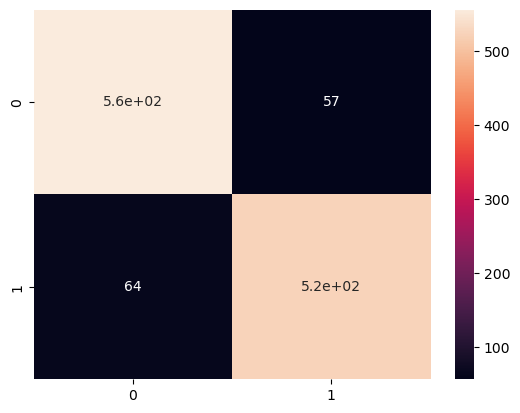

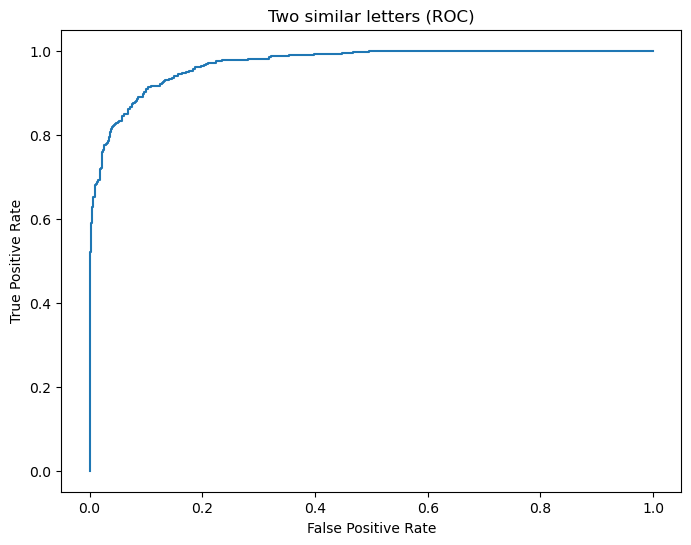

In [25]:
# Two similar letters:
label_1 = 'A'
label_2 = 'E'
logistic_regression_binary(label_1, label_2, target_size, 'Two similar letters (ROC)')

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1_score: 1.0
Classification Report: 
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       613
           G       1.00      1.00      1.00       587

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Confusion Matrix: 
AUC Score: 1.0


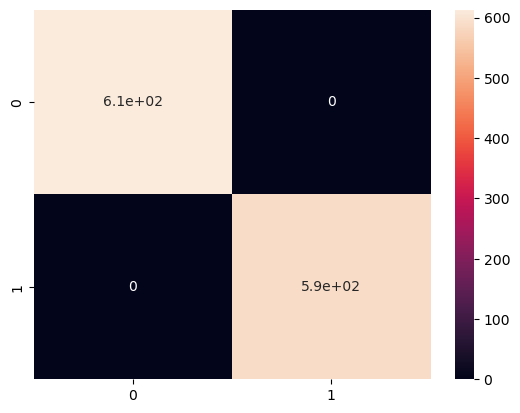

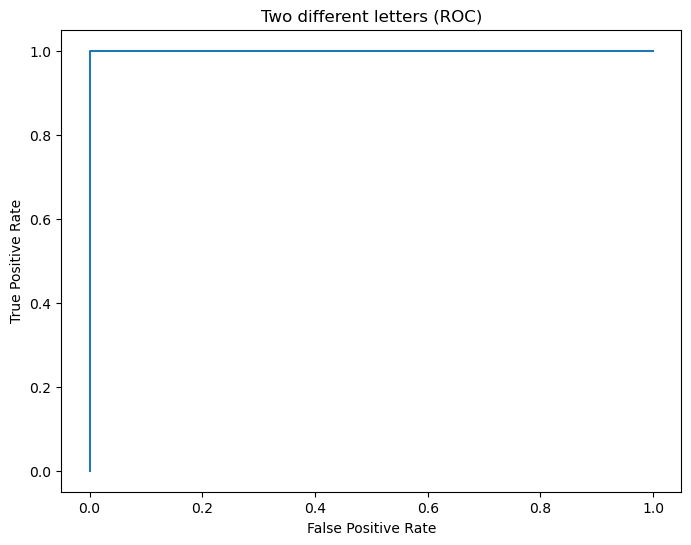

In [26]:
# Two different letters:
label_1 = 'C'
label_2 = 'G'
logistic_regression_binary(label_1, label_2, target_size, 'Two different letters (ROC)')

In [27]:
def logistic_regression_multiclass(size):
    """
    Train a logistic regression model with all the classes from the dataset.

    Args:
        size: the input of the image size
    """
    X, y = preprocess_images(size)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape the data from 3D to 2D
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print('Accuracy: ' + str(accuracy))
    print('Recall: ' + str(recall))
    print('Precision: ' + str(precision))
    print('F1_score: ' + str(f1))
    print('Classification Report: ')
    print(report)
    print('Confusion Matrix: ')
    sns.heatmap(conf_matrix, annot=True)

Accuracy: 0.49333333333333335
Recall: 0.49436993011483543
Precision: 0.4966779249466738
F1_score: 0.49349252144411004
Classification Report: 
              precision    recall  f1-score   support

           A       0.53      0.51      0.52       584
           B       0.49      0.48      0.48       574
           C       0.55      0.58      0.57       617
           D       0.46      0.44      0.45       589
           E       0.49      0.43      0.46       580
           F       0.53      0.45      0.49       585
           G       0.52      0.51      0.51       587
           H       0.55      0.56      0.56       599
           I       0.52      0.58      0.55       598
           J       0.57      0.49      0.53       610
           K       0.54      0.58      0.56       609
           L       0.65      0.61      0.63       641
           M       0.39      0.39      0.39       626
           N       0.51      0.51      0.51       587
           O       0.39      0.42      0.40    

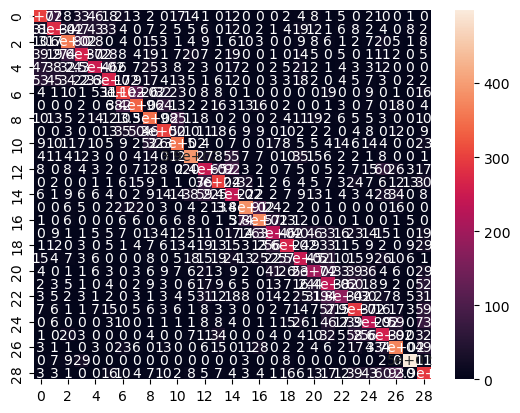

In [28]:
logistic_regression_multiclass(target_size)

The logistic regression performs relatively well, depending on the form of the input. 

- When the two letters are similar, the model performs relatively well; and accuracy and other scores are high.
  
- When the two letters are different, the model performs extremely well, with a 100% accuracy.
  
- When running with all letters the model does not perform well, better than expected (> 20%) but lower than good score (<80%)

=> This shows that the logistic regression can separate and classify hand signals especially well when the two labels are visually different.

As discussed, The logistic regression model is to be used as a baseline to compared to the main model - CNN. Because of high scores and accuracy of logistic regression models =>  we expecting CNNs will also perform well.

# CNN:

In [29]:
def cnn_models(cnn_model, size):
    """
    Train a CNN model using the given CNN model image size

    Args: 
        cnn_model: the given CNN model
        size: the input image size
    """
    X, y = preprocess_images(size)

    # Reshape from 3D to 4D gray scale
    X = X[..., np.newaxis]
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Compile and fit CNN model using adam optimizer, run 10 epchos with batch_siize of 64
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, verbose=1)

    # Evaluate the model based on loss and accuracy
    loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = cnn_model.predict(X_test, verbose=0)
    y_pred = y_pred_prob.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # Calculate the metrics
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print('Test Loss: ' + str(loss))
    print('Test Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F1: ' + str(f1))

    print('Classification Report: ')
    print(report)

    print('Confusion Matrix: ')
    sns.heatmap(conf_matrix, annot=True)

#### 1 hidden layers

In [30]:
# 1 hidden layer (32 Filters), Input Size (32, 32)
model1_32 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])
model1_32.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,847,709 (7.05 MB)

 Trainable params: 1,847,709 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.1327 - loss: 2.9763 - val_accuracy: 0.5435 - val_loss: 1.6418
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.3586 - loss: 1.9194 - val_accuracy: 0.6614 - val_loss: 1.1636
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.4407 - loss: 1.6004 - val_accuracy: 0.7374 - val_loss: 0.9561
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.4820 - loss: 1.4505 - val_accuracy: 0.7737 - val_loss: 0.8019
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5253 - loss: 1.3205 - val_accuracy: 0.7910 - val_loss: 0.7287
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5590 - loss: 1.2180 - val_accuracy: 0.8355 - val_loss: 0.6319
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5797 - loss: 1.1484 - val_accuracy: 0.8602 - val_loss: 0.5230
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6011 -

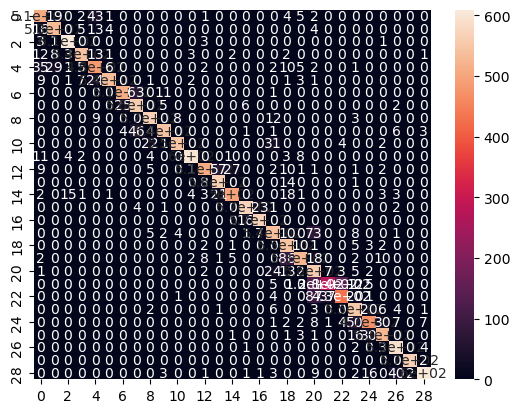

In [31]:
cnn_models(model1_32, target_size)

In [32]:
# 1 hidden layer (32 Filters), Input Size (16,16)
model1_16 = Sequential([
    Input(shape=(16, 16, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])
model1_32.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,543,129 (21.15 MB)

 Trainable params: 1,847,709 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,695,420 (14.10 MB)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1292 - loss: 3.0402 - val_accuracy: 0.4901 - val_loss: 1.9153
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3431 - loss: 2.0592 - val_accuracy: 0.6048 - val_loss: 1.4591
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4185 - loss: 1.7750 - val_accuracy: 0.6585 - val_loss: 1.2401
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4602 - loss: 1.6178 - val_accuracy: 0.6993 - val_loss: 1.0864
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4831 - loss: 1.5278 - val_accuracy: 0.7270 - val_loss: 1.0294
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5080 - loss: 1.4497 - val_accuracy: 0.7533 - val_loss: 0.9364
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5227 - loss: 1.3961 - val_accuracy: 0.7624 - val_loss: 0.8784
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5402 - loss: 1.3397 - 

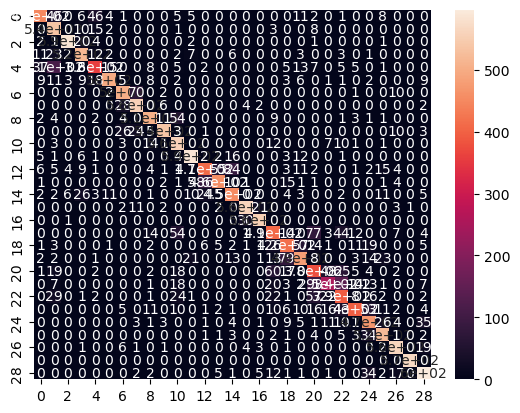

In [33]:
cnn_models(model1_16, reduced_size)

In [34]:
# 2 Hidden Layers (32, 64 Filters), Input Size (32, 32)
model2_32 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # Replace 29 with the number of classes
])
model2_32.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,597 (1.21 MB)

 Trainable params: 317,597 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.1873 - loss: 2.7926 - val_accuracy: 0.6614 - val_loss: 1.2117
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5222 - loss: 1.4539 - val_accuracy: 0.8032 - val_loss: 0.7412
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6134 - loss: 1.1372 - val_accuracy: 0.8509 - val_loss: 0.5593
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6730 - loss: 0.9536 - val_accuracy: 0.8933 - val_loss: 0.4377
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7129 - loss: 0.8258 - val_accuracy: 0.9075 - val_loss: 0.3651
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7350 - loss: 0.7593 - val_accuracy: 0.9298 - val_loss: 0.3035
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7629 - loss: 0.6757 - val_accuracy: 0.9394 - val_loss: 0.2769
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7837 -

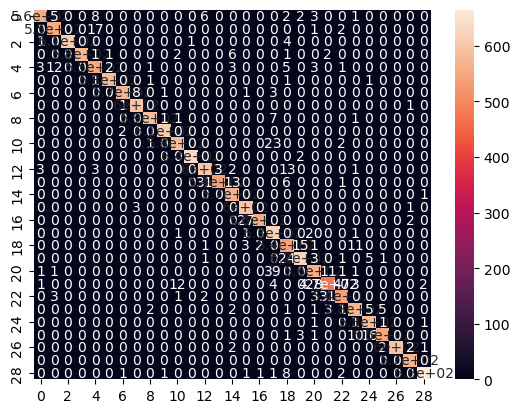

In [35]:
cnn_models(model2_32, target_size)

In [36]:
# 2 Hidden Layers (16, 32 Filters), Input Size (16, 16)
model2_16 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(reduced_size[0], reduced_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # Replace 29 with the number of classes
])
model2_16.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,941 (58.36 KB)

 Trainable params: 14,941 (58.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0736 - loss: 3.2442 - val_accuracy: 0.3537 - val_loss: 2.2463
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2703 - loss: 2.4026 - val_accuracy: 0.4653 - val_loss: 1.8332
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3362 - loss: 2.1242 - val_accuracy: 0.5016 - val_loss: 1.6482
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3740 - loss: 1.9792 - val_accuracy: 0.5670 - val_loss: 1.5000
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4005 - loss: 1.8729 - val_accuracy: 0.5726 - val_loss: 1.4123
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4179 - loss: 1.8107 - val_accuracy: 0.5992 - val_loss: 1.3484
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4312 - loss: 1.7668 - val_accuracy: 0.6200 - val_loss: 1.2941
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4410 - loss: 1.7216 - 

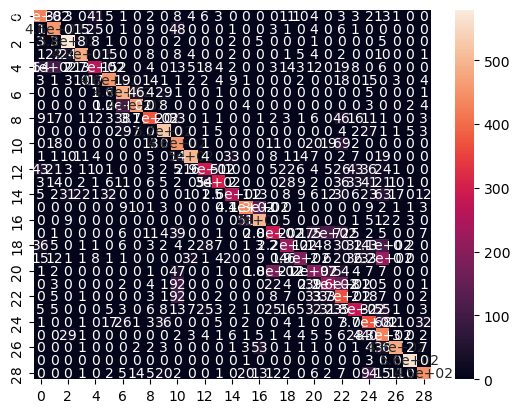

In [37]:
cnn_models(model2_16, reduced_size)

In [38]:
# 3 Hidden Layers (32, 64, 64 Filters), Input Size (32, 32)
model3_32 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])
model3_32.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,381 (360.86 KB)

 Trainable params: 92,381 (360.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.1786 - loss: 2.8243 - val_accuracy: 0.7181 - val_loss: 1.0145
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5835 - loss: 1.2464 - val_accuracy: 0.8301 - val_loss: 0.5702
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6959 - loss: 0.8997 - val_accuracy: 0.8612 - val_loss: 0.4654
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7445 - loss: 0.7346 - val_accuracy: 0.9086 - val_loss: 0.3480
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7798 - loss: 0.6339 - val_accuracy: 0.9301 - val_loss: 0.2712
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8017 - loss: 0.5655 - val_accuracy: 0.9423 - val_loss: 0.2150
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8219 - loss: 0.5123 - val_accuracy: 0.9514 - val_loss: 0.1866
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8374 -

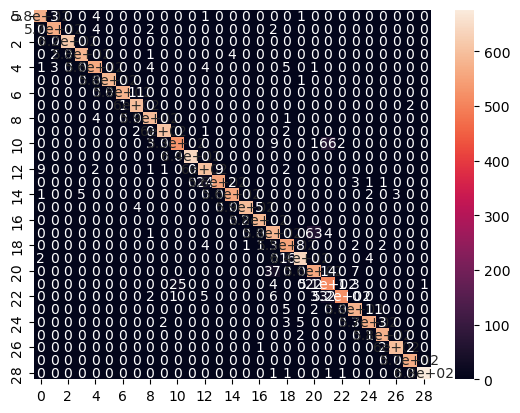

In [39]:
cnn_models(model3_32, target_size)

In [40]:
model3_16 = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(16, 16, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),  # Optional: Remove this pooling layer if still too small
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # Replace 29 with the number of classes
])

model3_16.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,189 (94.49 KB)

 Trainable params: 24,189 (94.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0883 - loss: 3.1623 - val_accuracy: 0.4003 - val_loss: 1.9517
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3119 - loss: 2.1426 - val_accuracy: 0.5518 - val_loss: 1.4715
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3927 - loss: 1.8415 - val_accuracy: 0.6257 - val_loss: 1.2638
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4351 - loss: 1.6817 - val_accuracy: 0.6784 - val_loss: 1.1159
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4646 - loss: 1.5828 - val_accuracy: 0.6920 - val_loss: 1.0505
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4916 - loss: 1.4975 - val_accuracy: 0.7038 - val_loss: 0.9644
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5100 - loss: 1.4424 - val_accuracy: 0.7282 - val_loss: 0.9043
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5228 - loss: 1.3918 - 

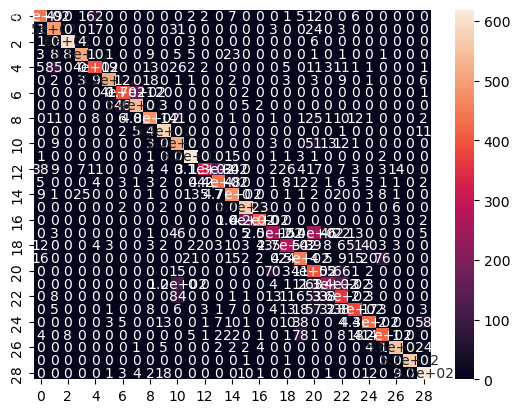

In [41]:
cnn_models(model3_16, reduced_size)

# ResNet18

References: 
- https://www.geeksforgeeks.org/resnet18-from-scratch-using-pytorch/ 
- https://github.com/samcw/ResNet18-Pytorch/blob/master/ResNet18.ipynb
- https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch

In [60]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [44]:
class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Optional, improves generalization
        
        self.layer1 = self._make_layer(block, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [45]:
def ResNet18(num_classes):
    return ResNet(BasicBlock, num_classes=num_classes)

##### ResNet18 model configuration

In [61]:
# Prepare data for PyTorch
X, y = preprocess_images(target_size)
X_scaled = np.stack([X, X, X], axis=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the ResNet model
num_classes = len(set(y))
model = ResNet18(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

##### Train the model

In [66]:
num_epochs = 3
final_correct_predictions = 0
final_total_predictions = 0
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
    
    all_preds_epoch = []
    all_labels_epoch = []

    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        _, preds = torch.max(outputs, 1) 
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        all_preds_epoch.extend(preds.cpu().numpy())
        all_labels_epoch.extend(labels.cpu().numpy())

        if (i + 1) % 10 == 0:
            progress_bar.set_postfix({'Loss': running_loss / 10})
            running_loss = 0.0

    epoch_loss /= len(train_loader)
    epoch_acc = correct_predictions / total_predictions
    final_correct_predictions += correct_predictions
    final_total_predictions += total_predictions

    all_preds.extend(all_preds_epoch)
    all_labels.extend(all_labels_epoch)
    
    print(f"Epoch {epoch + 1} Loss: {epoch_loss}, Accuracy: {epoch_acc}")

# Calculate and display final metrics
accuracy = final_correct_predictions / final_total_predictions
report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)

print('Final accuracy: ' + str(accuracy))
print('Classification Report: ', report)

Epoch 1/3: 100%|███████████████████████████████████████████████████████| 2719/2719 [20:52<00:00,  2.17it/s, Loss=0.045]


Epoch 1 Loss: 0.3858587820741919, Accuracy: 0.8732183908045977


Epoch 2/3: 100%|██████████████████████████████████████████████████████| 2719/2719 [21:31<00:00,  2.10it/s, Loss=0.0457]


Epoch 2 Loss: 0.06822262886630462, Accuracy: 0.9774942528735632


Epoch 3/3: 100%|██████████████████████████████████████████████████████| 2719/2719 [21:46<00:00,  2.08it/s, Loss=0.0453]


Epoch 3 Loss: 0.04270226070560743, Accuracy: 0.9871149425287357
Final accuracy: 0.9459425287356322
Classification Report:                precision    recall  f1-score   support

           A       0.95      0.95      0.95      9000
           B       0.94      0.95      0.95      9000
           C       0.98      0.97      0.97      9000
           D       0.96      0.96      0.96      9000
           E       0.93      0.92      0.93      9000
           F       0.97      0.97      0.97      9000
           G       0.95      0.95      0.95      9000
           H       0.95      0.95      0.95      9000
           I       0.96      0.96      0.96      9000
           J       0.96      0.96      0.96      9000
           K       0.95      0.95      0.95      9000
           L       0.96      0.97      0.97      9000
           M       0.92      0.91      0.91      9000
           N       0.92      0.91      0.91      9000
           O       0.94      0.94      0.94      9000
           P